In [6]:
!pip install xgboost    

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [11]:
import xgboost as xgb
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [12]:
power_plant = pd.read_excel("Folds5x2_pp.xlsx")


X = power_plant.drop("PE", axis = 1)   # Drop PE from independent variables
y = power_plant['PE'].values           # Hold PE as the dependent variable. PE - Net Hourly Power ouput

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=1)

In [13]:
# Xgb takes data in matrix form both for training and testing...

DM_train = xgb.DMatrix(data = X_train,  #Take the data in special format in Dmatrix format
                       label = y_train)  
DM_test =  xgb.DMatrix(data = X_test,
                       label = y_test)

In [14]:
# setting the hyper parameters ... Ref https://xgboost.readthedocs.io/en/latest/python/python_api.html

gbm_param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5),  # generate 5 numbers between .5 and .9 #Key value pair
     'n_estimators':[10, 200],          #No. of trees from iteration 20 to 200
     'max_depth': [10, 15, 20, 25]
}       

In [15]:
gbm = xgb.XGBRegressor()

In [16]:
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)

In [17]:
#Random search cv is also there

In [18]:
grid_mse.fit(X_train, y_train)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.2min finished


Best parameters found:  {'colsample_bytree': 0.8, 'max_depth': 15, 'n_estimators': 200}
Lowest RMSE found:  3.192780782426709


In [19]:
pred = grid_mse.predict(X_test)
print("Root mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, pred)), 2)))

Root mean square error for test dataset: 2.88


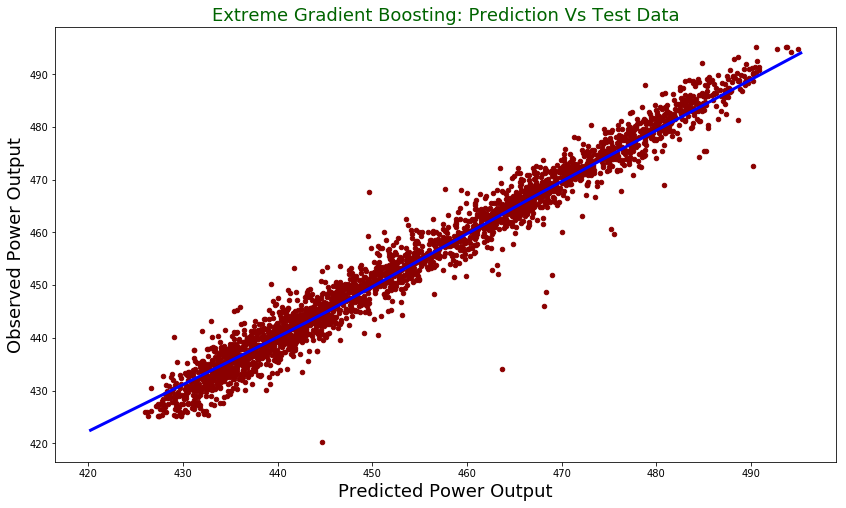

In [20]:
test = pd.DataFrame({"prediction": pred, "observed": y_test.flatten()})
lowess = sm.nonparametric.lowess
z = lowess(pred.flatten(), y_test.flatten())
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("Extreme Gradient Boosting: Prediction Vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted Power Output", fontsize = 18) 
plt.ylabel("Observed Power Output", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()